In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sympy import diff, symbols, Symbol, integrate, solve, sqrt, log, sin, cos, lambdify
%matplotlib inline

# Задание 1. Линейные системы. Устойчивость численных методов.

Решить численно задачу о колебаниях в системе, где и возвращающая сила, и
коэффициент вязкого трения убывают со временем (уравнение Эйлера):
$$
\ddot{x} + 100\,\dfrac{x}{t^2} = 0
$$ 
Сначала решим численно!
Подстановка $x = t^\alpha$ дает следующее уравнение:
$$
\boxed{
    x (t) = C_1 \sqrt{t} \sin \left( \frac{1}{2} \sqrt{399} \ln{t} \right) + C_2 \sqrt{t} \cos \left( \frac{1}{2} \sqrt{399} \ln{t} \right)
}
$$

In [2]:
# Запишем решение
C1, C2, t = symbols('C1 C2 t')
sol = C1*sqrt(t)*sin(0.5*sqrt(399)*log(t)) \
                        + C2*sqrt(t)*cos(0.5*sqrt(399)*log(t))
sol_d1 = lambdify(t, diff(sol, t))
C1_sol, C2_sol = list(solve([sol_d1(1) - 1, sol.subs(t, 1) - 1]).values())
t_theor = lambdify(t, sol.subs(C1, C1_sol).subs(C2, C2_sol))

In [125]:
def compare_results(theor, predicted):
    print('  Вычисленное x(101) = ' + str(predicted))
    print('  Теоретическое x(101) = ' + str(theor))
    
def plot_lines(*args, **kwargs):
    for (x_data, y_data) in args:
        plt.plot(x_data, y_data, **kwargs)
    plt.grid()
    plt.show()

In [126]:
system_of_eq = lambda t, x: np.array([
    1.0,  # Время
    x[2],  # x точка
    -100.0*x[1]/x[0]**2,  # p точка
])

In [127]:
x_start = np.array([1.0, 1.0, 1.0])
t_stop = 101.0
t_range = np.linspace(x_start[0], t_stop, 1000)
x_range = t_theor(t_range)
h = 0.1

## Методы Эйлера

Для решения методом Эйлера разобьем на нормальную систему уравнений:

$$
\begin{cases}
    \dot{x} = p \\
    \dot{p} = -100\, \cfrac{x}{t^2}
\end{cases}
$$

### Явный метод Эйлера

In [122]:
# Явный метод Эйлера
def eiler_1(funcs, x_start, t_stop, h=0.1):
    # Начальное значение
    x = x_start
    y = [x_start.copy()]
    while x[0] < t_stop:
        x += h*funcs(x)
        y.append(x.copy())
    return y

In [123]:
# Параметр времени не используется, но мы передаем его для правильной работы scipy
x_1 = eiler_1(lambda x: system_of_eq(0, x), x_start.copy(), t_stop, h)

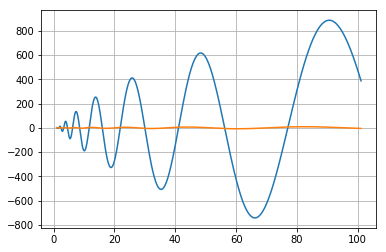

In [128]:
x_1_np = np.array(x_1).T
t_pred = x_1_np[0]
x_pred = x_1_np[1]
plot_lines((t_pred, x_pred), (t_range, x_range))

In [9]:
compare_results(t_theor(t_stop), x_1[-1][1])

  Вычисленное x(101) = 387.60543228423273
  Теоретическое x(101) = -4.73890168470781


Результаты очень плохие. Это объясняется тем, что явный метод Эйлера дает ошибку $o (h)$, которая в нашем случае оказалась велика.

### Неявный метод Эйлера

In [10]:
# Неявный метод Эйлера
def eiler_2(funcs, x_start, t_stop, h=0.1):
    # Начальное значение
    x = x_start
    y = [x_start.copy()]
    while x[0] < t_stop:
        # Прогноз
        x_tmp_tmp = x + h*funcs(x)
        # Пересчет
        x_tmp = x + h*(funcs(x) + funcs(x_tmp_tmp))/2
        x += h*(funcs(x) + funcs(x_tmp))/2
        y.append(x.copy())
    return y

In [11]:
# Параметр времени не используется, но мы передаем его для правильной работы scipy
x_2 = eiler_2(lambda x: system_of_eq(0, x), x_start.copy(), t_stop, h)

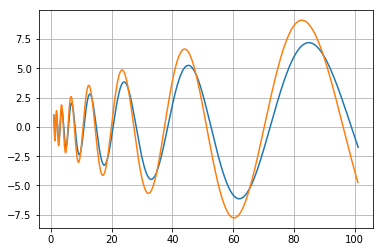

In [12]:
x_2_np = np.array(x_2).T
t_pred = x_2_np[0]
x_pred = x_2_np[1]
plot_lines((t_pred, x_pred), (t_range, x_range))

In [13]:
compare_results(t_theor(t_stop), x_2[-1][1])

  Вычисленное x(101) = -1.7472631764270972
  Теоретическое x(101) = -4.73890168470781


Неявный метод Эйлера дает неплохие результаты. Более того, он оказывается самым точным, поскольку дает точность $o(h^2)$, к тому же, имеет повышенную устройчивость и позволяет обойти некоторые проблемы при решении жестких систем ДУ.

### Метод Эйлера с центральной точкой

In [14]:
# метод Эйлера с центральной точкой
def eiler_3(funcs, x_start, t_stop, h=0.1):
    # Начальное значение
    x = x_start
    y = [x_start.copy()]
    while x[0] < t_stop:
        # Нам придется "подгядеть" f_(i+1), а затем взять полусумму с f_i
        x_tmp = (funcs(x + h*funcs(x)) + funcs(x))/2
        # Результат прибавлять в качестве вектора касательной
        x += h*x_tmp
        y.append(x.copy())
    return y

In [15]:
# Параметр времени не используется, но мы передаем его для правильной работы scipy
x_3 = eiler_3(lambda x: system_of_eq(0, x), x_start.copy(), t_stop, h)

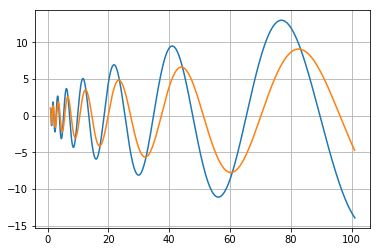

In [16]:
x_3_np = np.array(x_3).T
t_pred = x_3_np[0]
x_pred = x_3_np[1]
plot_lines((t_pred, x_pred), (t_range, x_range))

In [17]:
compare_results(t_theor(t_stop), x_3[-1][1])

  Вычисленное x(101) = -13.961618490145836
  Теоретическое x(101) = -4.73890168470781


Метод Эйлера с центральной точкой дает результаты лучше явного, но хуже неявного (из-за меньшей устойчивости по сравнению с неявным).

## Метод Дормана-Принса

In [18]:
from scipy.integrate import solve_ivp

In [19]:
x_4 = solve_ivp(system_of_eq, (x_start[0], t_stop), x_start, method='RK45', t_eval=np.arange(x_start[0], t_stop, h))

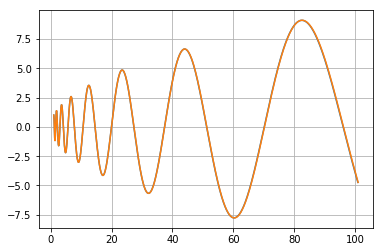

In [20]:
x_4_np = x_4.y
t_pred = x_4_np[0]
x_pred = x_4_np[1]
plot_lines((t_pred, x_pred), (t_range, x_range))

In [21]:
compare_results(t_theor(t_stop), x_4.y[1][-1])

  Вычисленное x(101) = -4.730878086598228
  Теоретическое x(101) = -4.73890168470781


Метод Дормана-Принса дает очень хорошие результаты интегрирования. Его точность составляет $o(h^4)$.

## Метод трапеций

In [22]:
# TODO: придумай, что делать с методом трапеций
def trapezium(funcs, x_start, t_stop, h=0.1):
    # Начальное значение
    x = x_start
    y = [x_start.copy()]
    while x[0] < t_stop:
        # Нам придется "подгядеть" f_(i+1), а затем взять полусумму с f_i
        x_tmp = x + h*funcs(0, x)
        # Результат прибавлять в качестве вектора касательной
        x += h*x_tmp
        y.append(x.copy())
    return y

In [23]:
x_5 = trapezium(system_of_eq, x_start, t_stop, h)

# Задание 2. Нелинейная система уравнений

Уравнение Ван-дер-Поля
$$
y'' + a (y^2 - 1) y' + y = 0 \\
y(0) = y_0 > 0; ~ y'(0) = 0, ~ 0 \leq t \leq 30, ~ a > 0 ~ (100 \div 1000)
$$

1) Проинтегрировать уравнение численно явными методами Рунге-Кутты с числом стадий 2, 3 и 4 с процедурой автоматического выбора шага.

Для этого представим уравнение в виде системы:
$$
\begin{cases}
    y' = -p \\
    p' = ap (y^2 - 1) + y
\end{cases}
$$

In [217]:
def runge_kutta(system, y_0_range, a_range, t_range, number_of_stages):
    y_0_range = list(map(lambda v: np.array([v, 0]), y_0_range))
    if number_of_stages == 4:
        method = 'RK45'
    elif number_of_stages == 3:
        method = 'RK23'
    elif number_of_stages == 2:
        method = 'RK23'
    for y_0 in y_0_range:
        y_0 = y_0.copy()
        print('y_0 is:')
        print(y_0)
        data = []
        for a in a_range:
            sol = solve_ivp(lambda x, y: system_of_eq(a, x, y), (t_min, t_max), y_0, t_eval=t_range.copy(), method=method).y.copy()
            data.append((sol[0], sol[1]))
        plot_lines(*data)

In [218]:
y_0_range = [-100.1, -10.1, -1.1, -0.1, 0, 0.1, 1.1, 10.1, 100.1]
#a_range = np.concatenate((np.arange(0, 1, 0.05), np.arange(1, 5, 0.1), np.arange(5, 80, 1)))
a_range = np.arange(100, 1000, 50)
t_min, t_max = 0, 30
system_of_eq = lambda a, x, y: [
    -y[0], 
    a*y[1]*(y[0]**2 - 1) + y[0]
]
t_range = np.arange(t_min, t_max, 0.01)

Для числа стадий 4:

y_0 is:
[-100.1    0. ]


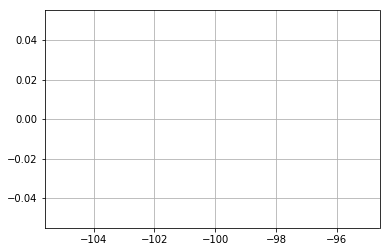

y_0 is:
[-10.1   0. ]


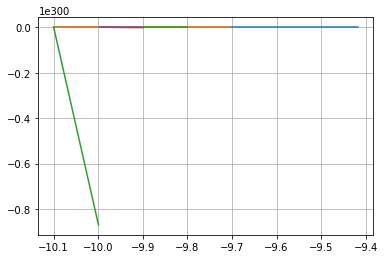

y_0 is:
[-1.1  0. ]


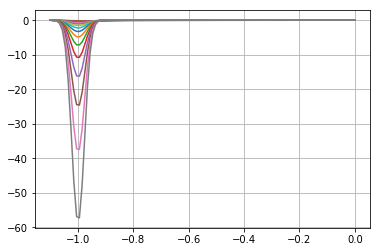

y_0 is:
[-0.1  0. ]


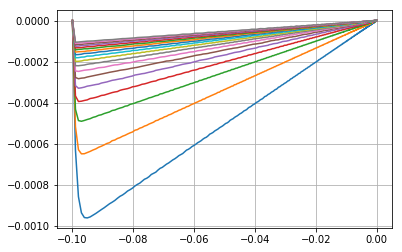

y_0 is:
[0 0]


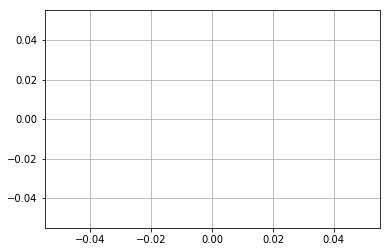

y_0 is:
[0.1 0. ]


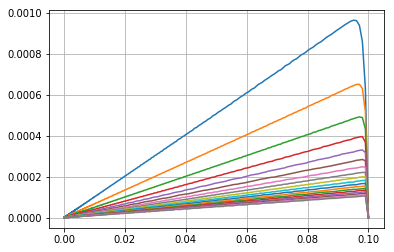

y_0 is:
[1.1 0. ]


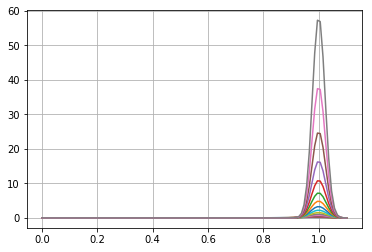

y_0 is:
[10.1  0. ]


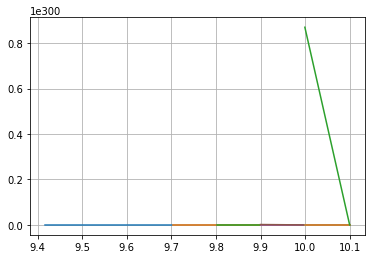

y_0 is:
[100.1   0. ]


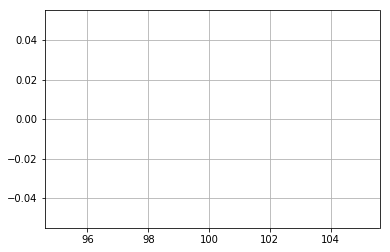

In [219]:
runge_kutta(system=system_of_eq, y_0_range=y_0_range, a_range=a_range, t_range=t_range, 
            number_of_stages=4)

Для числа стадий 3:

y_0 is:
[-100.1    0. ]


/Users/aleksei/github_projects/calc_math-labs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in double_scalars
  import sys


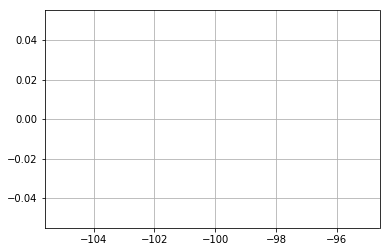

y_0 is:
[-10.1   0. ]


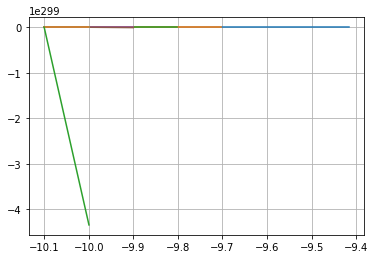

y_0 is:
[-1.1  0. ]


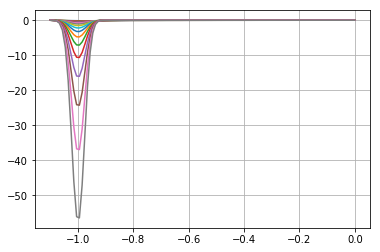

y_0 is:
[-0.1  0. ]


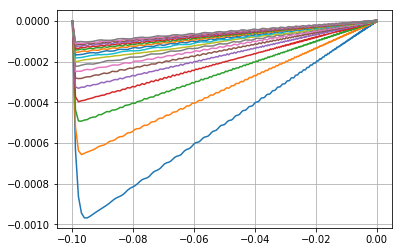

y_0 is:
[0 0]


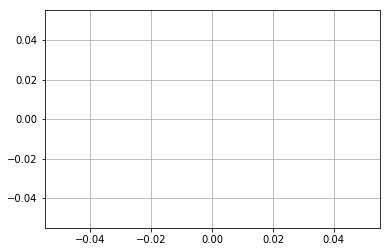

y_0 is:
[0.1 0. ]


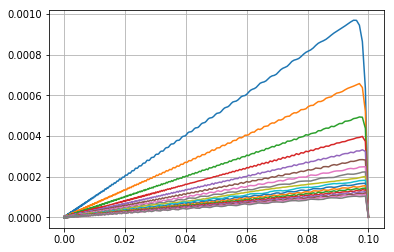

y_0 is:
[1.1 0. ]


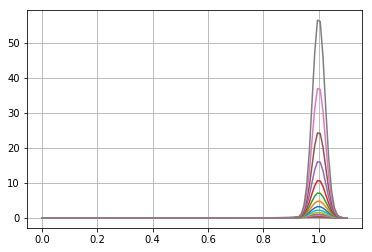

y_0 is:
[10.1  0. ]


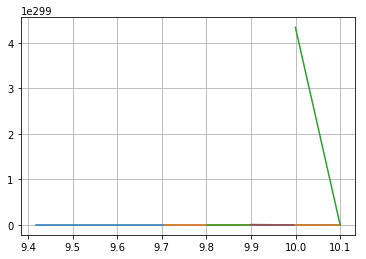

y_0 is:
[100.1   0. ]


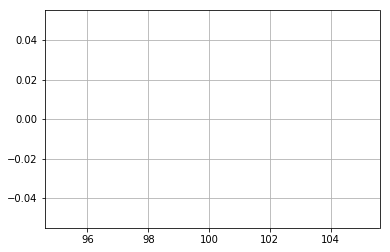

In [220]:
runge_kutta(system=system_of_eq, y_0_range=y_0_range, a_range=a_range, t_range=t_range, 
            number_of_stages=3)

Для числа стадий 2:

y_0 is:
[-100.1    0. ]


/Users/aleksei/github_projects/calc_math-labs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in double_scalars
  import sys


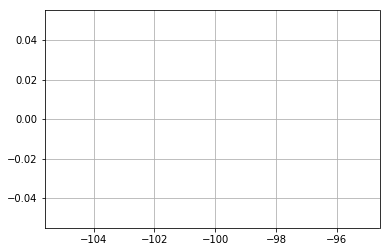

y_0 is:
[-10.1   0. ]


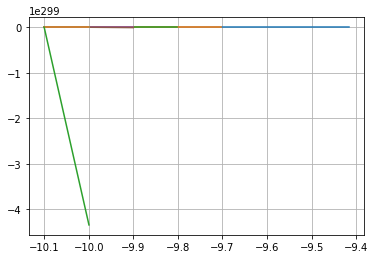

y_0 is:
[-1.1  0. ]


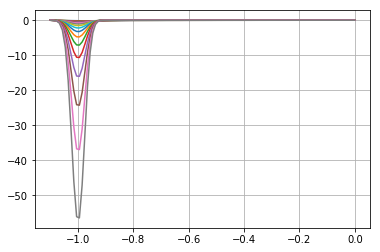

y_0 is:
[-0.1  0. ]


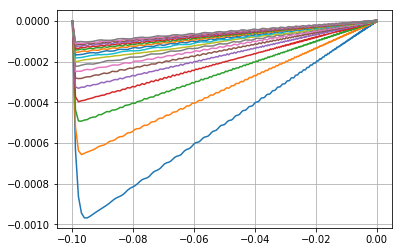

y_0 is:
[0 0]


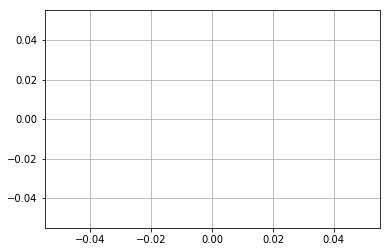

y_0 is:
[0.1 0. ]


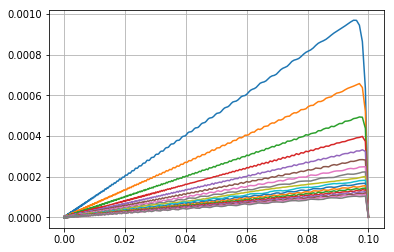

y_0 is:
[1.1 0. ]


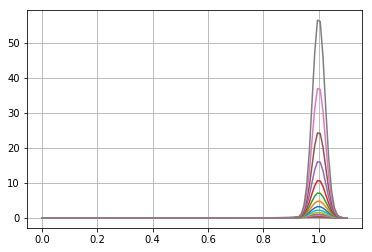

y_0 is:
[10.1  0. ]


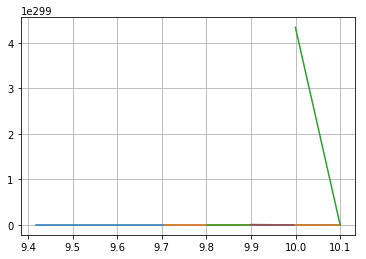

y_0 is:
[100.1   0. ]


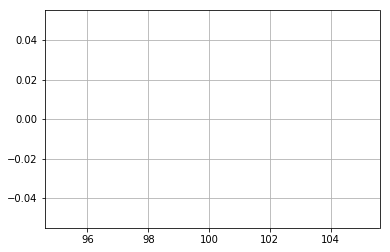

In [221]:
runge_kutta(system=system_of_eq, y_0_range=y_0_range, a_range=a_range, t_range=t_range, 
            number_of_stages=2)

При большом значении $y_0$ решение системы расходилось. Это объясняется тем, что при разных начальных параметрах мы приходим в разные особые точки.

# Задание 3. Особые точки и особые траектории.

Система ОДУ,
описывающая динамику образования основных метаболитов в реакции свертывания крови:
$$
    \cfrac{\partial u_1}{t} = K_1 u_1 u_2 (1 - u_1) \cfrac{1 + K_2 u_1}{1 + K_3 u_3} - u_1 \\
    \cfrac{\partial u_2}{t} = u_1 - K_4 u_2 \\
    \cfrac{\partial u_3}{t} = K_5 u_1^2 - K_6 u_3
$$
Особые точки рассматриваемой системы определяются корнями следующего полинома:
$$
f (u_1) = u_1 \left(\dfrac{K_1 K_2}{K_4} u_1^3 + \left( \dfrac{K_1}{K_4} (1 - K_2) + \dfrac{K_3 K_5}{K_6} \right) u_1^2 - \dfrac{K_1}{K_4} u_1 + 1 \right)
$$
В системе всегда существует нулевая особая точка. Она устойчива при любых значениях параметров. Кроме того, у этого полинома всегда есть отрицательный корень. Количество положительных корней, определяющих особые точки системы, может меняться в зависимости от параметров модели от нуля до двух.

Табличные данные: $K_1 = 6.85; ~~ K_2 = 11.0; ~~ K_3 = 2.36; ~~ K_4 = 0.087; ~~ K_5 = 17.0$

In [228]:
K1, K2, K3, K4, K5 = 6.85, 11.0, 2.36, 0.087, 17.0
u_1, K_1, K_2, K_3, K_4, K_5, K_6 = symbols('u_1 K_1 K_2 K_3 K_4 K_5 K_6')

In [229]:
eq = K_1*K_2/K_4 * u_1**3 + (K_1/K_4*(1-K_2) + K_3*K_5/K_6)*u_1**2 - K_1/K_4*u_1 + 1

In [236]:
eq_s = eq.subs(K_1, K1)\
.subs(K_2, K2)\
.subs(K_3, K3)\
.subs(K_4, K4)\
.subs(K_5, K5)

In [246]:
from sympy import solve
k6_range = np.linspace(0, 0.2, 100)[1:]
for k6 in k6_range:
    # Получаем все решения
    solutions = solve(eq_s.subs(K_6, k6), u_1)
    print(solutions)

[-22.0249368341457, 0.00206496650882878 - 0.00693965758428564*I, 0.00206496650882878 + 0.00693965758428564*I]
[-10.5644735112880, 0.00430775763470118 - 0.00952550076207342*I, 0.00430775763470118 + 0.00952550076207342*I]
[-6.74770631101983, 0.00674897501887536 - 0.0112054934146036*I, 0.00674897501887536 + 0.0112054934146036*I]
[-4.84220709572664, 0.00941177613140193 - 0.0122419726634094*I, 0.00941177613140193 + 0.0122419726634094*I]
[-3.70153277324665, 0.0123220601468823 - 0.0126528597498031*I, 0.0123220601468823 + 0.0126528597498031*I]
[-2.94357587744130, 0.0155085757478587 - 0.0123179583908375*I, 0.0155085757478587 + 0.0123179583908375*I]
[-2.40461455974347, 0.0190028908301217 - 0.0109112403355683*I, 0.0190028908301217 + 0.0109112403355683*I]
[-2.00282459713533, 0.0228391399744332 - 0.00740711904592635*I, 0.0228391399744332 + 0.00740711904592635*I]
[-1.6927823921636 - 0.e-25*I, 0.0199958707195358 + 0.e-23*I, 0.0341110071773071 - 0.e-23*I]
[-1.44726453703257 + 0.e-24*I, 0.0173296858389

[-0.128163282585108 + 0.e-23*I, 0.011732146175889 + 0.e-21*I, 0.767882744261712 - 0.e-22*I]
[-0.127789199324413 - 0.e-23*I, 0.0117284235749499 + 0.e-23*I, 0.770375042504606 - 0.e-22*I]
[-0.127425321978117 + 0.e-21*I, 0.0117247871988148 + 0.e-21*I, 0.772814544856816 - 0.e-22*I]
[-0.127071240662113 - 0.e-23*I, 0.0117212340842457 + 0.e-23*I, 0.775202895992483 - 0.e-22*I]
[-0.126726567040772 - 0.e-23*I, 0.0117177614023254 + 0.e-23*I, 0.77754167375926 - 0.e-22*I]
[-0.126390932936197 + 0.e-21*I, 0.0117143664509284 + 0.e-21*I, 0.779832392488742 - 0.e-22*I]
[-0.126063989043292 - 0.e-23*I, 0.0117110466476917 + 0.e-23*I, 0.782076506115783 - 0.e-22*I]
[-0.125745403741425 + 0.e-23*I, 0.011707799523449 - 0.e-23*I, 0.784275411119105 - 0.e-22*I]
[-0.125434861994353 + 0.e-23*I, 0.0117046227160925 + 0.e-21*I, 0.786430449294747 - 0.e-22*I]
[-0.125132064330889 + 0.e-23*I, 0.0117015139648296 + 0.e-23*I, 0.788542910373101 - 0.e-22*I]
[-0.124836725899509 + 0.e-21*I, 0.0116984711048061 + 0.e-21*I, 0.79061403